# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.769782,True,2.714236
1,-0.971834,False,-0.986104
2,-1.968697,True,-0.574426
3,-1.991078,False,-5.947173
4,0.754661,False,2.550966
...,...,...,...
995,-0.743991,True,3.368132
996,-1.018581,False,-2.951918
997,-0.303651,False,-0.550223
998,-1.282030,True,1.426503


<AxesSubplot: xlabel='v0'>

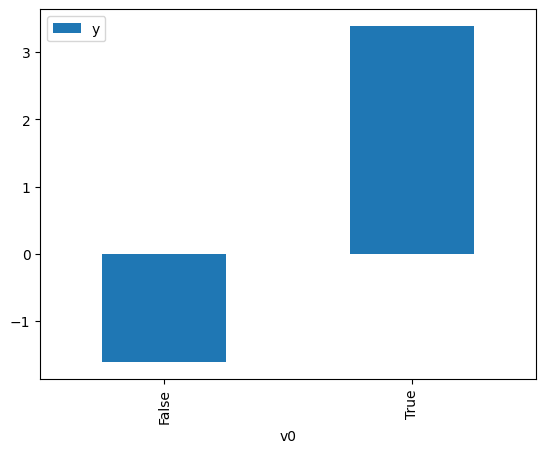

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

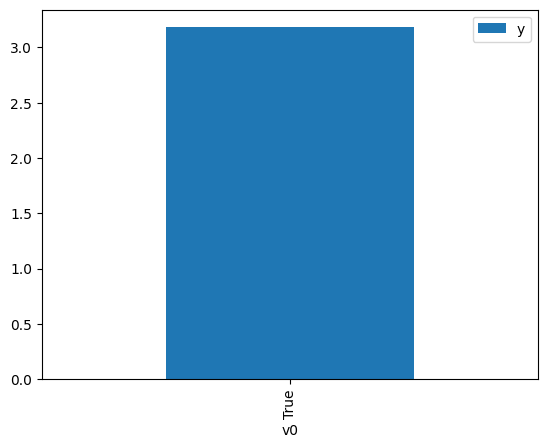

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.539444,False,1.017772,0.570302,1.753457
1,-0.614429,False,-2.218186,0.578779,1.727776
2,-2.590375,False,-5.587529,0.774098,1.291826
3,-3.348331,False,-7.655828,0.829507,1.205536
4,-0.912993,False,-1.946286,0.612027,1.633914
...,...,...,...,...,...
995,-0.217138,False,-0.920647,0.533456,1.874569
996,-2.424274,False,-5.840532,0.760383,1.315127
997,0.286530,False,1.436699,0.475292,2.103969
998,-1.018581,False,-2.951918,0.623557,1.603702


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.389199,True,4.201833,0.446802,2.238125
1,-1.880283,True,1.007265,0.288395,3.467471
2,-1.130900,True,2.349306,0.364330,2.744765
3,1.330229,True,8.766677,0.641436,1.559003
4,-0.560424,True,3.691439,0.427322,2.340157
...,...,...,...,...,...
995,-0.204208,True,2.849573,0.468033,2.136603
996,-0.207951,True,2.209933,0.467602,2.138572
997,1.073381,True,5.335867,0.613681,1.629510
998,-1.217124,True,1.191471,0.355146,2.815746


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              8064.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:28:26   Log-Likelihood:                         -1353.5
No. Observations:                1000   AIC:                                      2711.
Df Residuals:                     998   BIC:                                      2721.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3607      0.025     92.688      0.000       2.311       2.411
x2             5.0222      0.047    106.282      0.000       4.929       5.115
==============================================================================
Omnibus:                        4.535   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.591
Skew:                          -0.151   Prob(JB):                        0.101
Kurtosis:                       2.864   Cond. No.                         1.95
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""